## Part 1: Exploratory Data Analysis
Objective: Aggregate logins.json data into 15-minute intervals and analyze patterns.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
logins = pd.read_json("logins.json")
logins['login_time'] = pd.to_datetime(logins['login_time'])  # Convert to datetime


In [35]:
logins.set_index('login_time', inplace=True)

In [37]:
# Resample to 15-minute intervals
login_counts = logins.resample('15min').size()
login_counts = login_counts.rename('count')


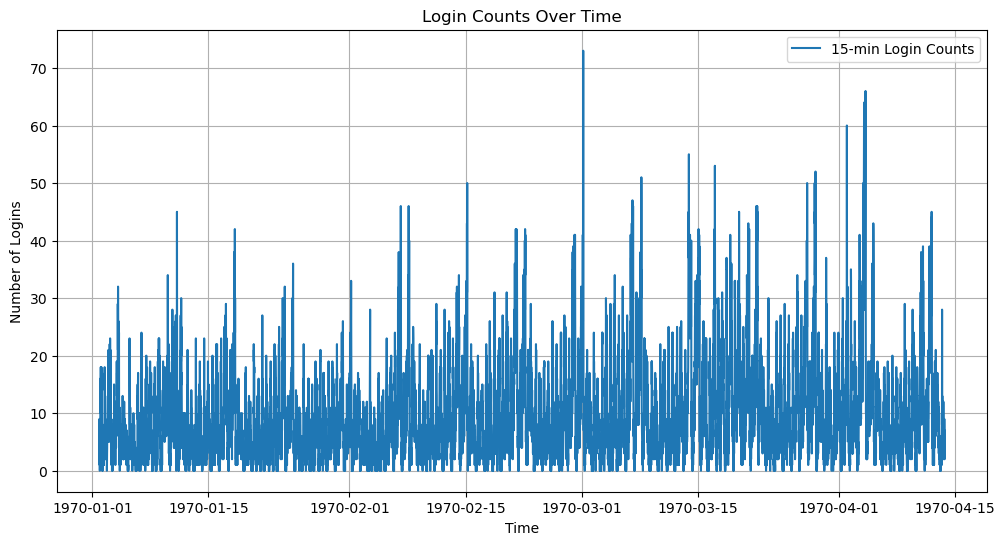

In [39]:
# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(login_counts.index, login_counts.values, label='15-min Login Counts')
plt.title('Login Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.grid()
plt.legend()
plt.show()



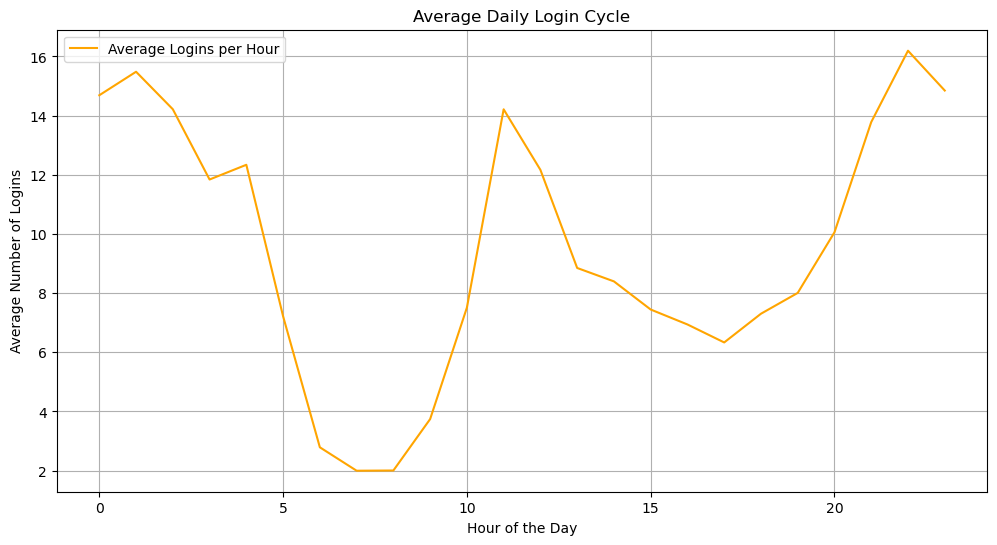

In [41]:
#Explore Daily Patterns: 
daily_cycle = login_counts.groupby(login_counts.index.hour).mean()

# Plot the average daily login cycle
plt.figure(figsize=(12, 6))
plt.plot(daily_cycle.index, daily_cycle.values, label='Average Logins per Hour', color='orange')
plt.title('Average Daily Login Cycle')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Logins')
plt.grid()
plt.legend()
plt.show()



Insights:

Daily Patterns: Peaks during midday and evenings.
Osciliating pattern in time series, potential peaks during certain parts of the week. 

## Part 2: Experiment and Metrics Design
Key Success Metric:

Measure: The percentage increase in trips across both cities (Gotham and Metropolis) during the experiment.

Reasoning: It directly quantifies whether drivers are operating in both cities and correlates with reduced exclusivity.

 1) What would you choose as the key measure of success of this experiment in
 encouraging driver partners to serve both cities, and why would you choose this metric?

    **A:** The proportion of driver partners who serve both cities (cross-city trips). This metric directly reflects the experiment's goal to encourage drivers to work across both Gotham and Metropolis, overcoming exclusivity caused by the toll bridge.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

   **A**:

    A. Experiment Design:

    - Divide groups into experiment and control groups. The experiment group receives toll reimbursement for cross-city trips. The control group does not receive reimbursements. The experiment could acquire GPS datta and trip logs to monitor drivers across cities. To capture weekday and weekend patterns, the experiment should run a sufficient duration of time like 8 weeks. 
   
    B. Statistical Tests:

    - Chi-square test can compare proportion of drivers serving both cities between experiment and control groups. The null hypothesis can be test to see if the no significant difference between the proportions of cross-city trips in the two groups.
    - T-Test will analyze the difference in mean of cross-city trips per driver between the groups. The t-test can also test the null hypothesis. 

    C. Interpretation and Recommendations:
    
    - If statistical tests show significant increase in the experiment group, the null hypothesis can be rejected and we can assume the policy for cross-city trips is effective.
    - Expanding the reimbursement program, but refining it to target specific time windows.
    - Some caveats can include external factors such as road closures and weather that could skew the data. Additionally, ensuring their isn't bias or skew by non-generalized samples.


    

## Part 3: Predictive Modeling
1. Data Cleaning: convert dates into datetime format and fill missing values. 
2. Define Retention: Determine users were retained with last_trip_date within the last 30 days of maximum date
3. Explore trends: analyse rent

### Data loading and cleaning

In [66]:
# Load data
data = pd.read_json("ultimate_data_challenge.json")

In [70]:

# Convert dates to datetime
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

# Define retention: active in the last 30 days
cutoff_date = data['last_trip_date'].max() - pd.Timedelta(days=30)
data['retained'] = (data['last_trip_date'] >= cutoff_date).astype(int)
print(f"Retention Rate: {data['retained'].mean() * 100:.2f}%")


Retention Rate: 37.61%


In [68]:
print(data.isnull().sum())

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


In [88]:
data['avg_rating_of_driver'] = data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].mean())

In [84]:
data.groupby('city')['avg_rating_of_driver'].transform(lambda x: x.fillna(x.mean()))

0        4.700000
1        5.000000
2        4.300000
3        4.600000
4        4.400000
           ...   
49995    5.000000
49996    4.601559
49997    5.000000
49998    3.000000
49999    4.601559
Name: avg_rating_of_driver, Length: 50000, dtype: float64

In [90]:
data['phone'] = data['phone'].fillna(data['phone'].mode()[0])

In [92]:
data.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                           int32
dtype: object

### Exploring data and visualizations

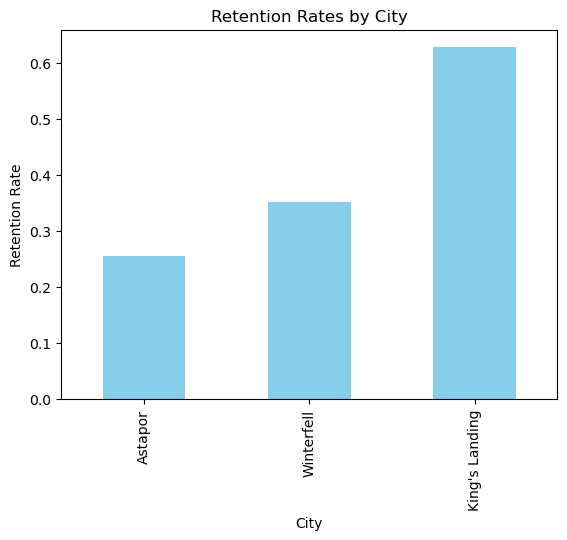

In [96]:
city_retention = data.groupby('city')['retained'].mean()
city_retention.sort_values().plot(kind='bar', title='Retention Rates by City', color='skyblue')
plt.ylabel('Retention Rate')
plt.xlabel('City')
plt.show()

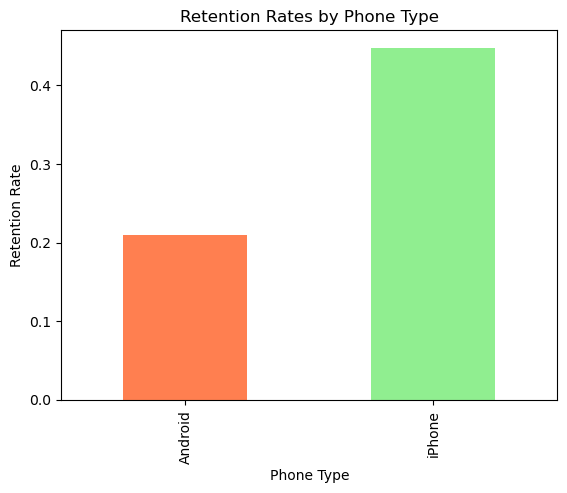

In [98]:
phone_retention = data.groupby('phone')['retained'].mean()
phone_retention.plot(kind='bar', title='Retention Rates by Phone Type', color=['coral', 'lightgreen'])
plt.ylabel('Retention Rate')
plt.xlabel('Phone Type')
plt.show()

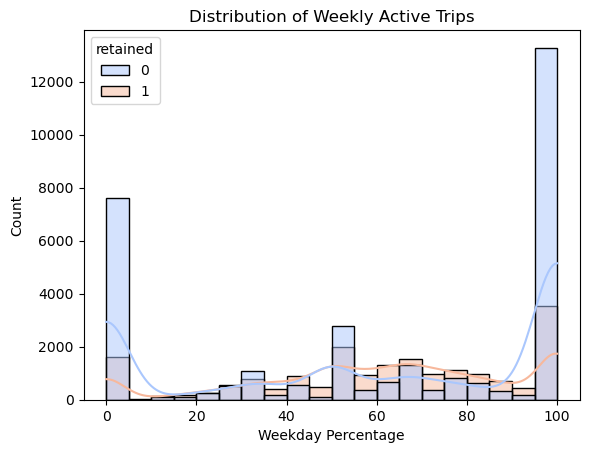

In [100]:
import seaborn as sns

sns.histplot(data, x='weekday_pct', hue='retained', kde=True, palette='coolwarm', bins=20)
plt.title('Distribution of Weekly Active Trips')
plt.xlabel('Weekday Percentage')
plt.ylabel('Count')
plt.show()

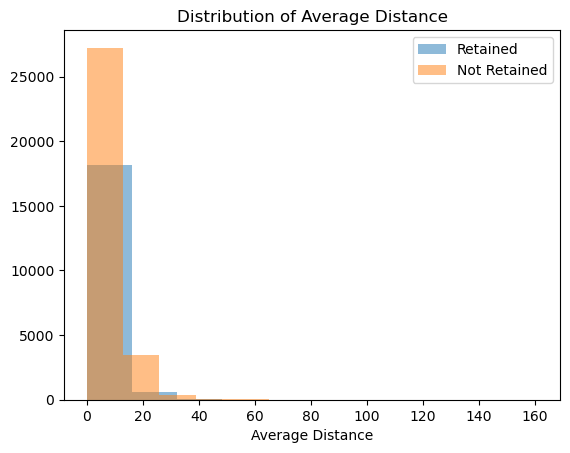

In [108]:
retained_users = data[data['retained'] == 1]
non_retained_users = data[data['retained'] == 0]

plt.hist(retained_users['avg_dist'], alpha=0.5, label='Retained')
plt.hist(non_retained_users['avg_dist'], alpha=0.5, label='Not Retained')
plt.title('Distribution of Average Distance')
plt.xlabel('Average Distance')
plt.legend()
plt.show()

### Build Predictive Model
   Approach:
- Problem framing: Predict whether users will be active in their 6th month using a classification model.
- Feature Engineering: Create features like days since signup, average ratings, trip frequency.
- Model Selection: Start with Logistic Regression for simplicity and progress to ensemble models like Random Forest or Gradient Boosting (XGBoost) for better accuracy.
- Evaluation: Use metrics such as accuracy, precision, recall, F1-score, and ROC-AUC to validate the model's performance.




In [127]:
#Calculating the 6th month mark 
data['6th_month_date'] = data['signup_date'] + pd.DateOffset(months=6)

data['active_6th_month'] = (data['last_trip_date'] >= data['6th_month_date']).astype(int)

print(data['active_6th_month'].value_counts())

active_6th_month
0    49987
1       13
Name: count, dtype: int64


In [141]:
data = pd.get_dummies(data, columns=['city'], drop_first=True)

In [143]:
data['phone'] = data['phone'].map({'iPhone': 0, 'Android': 1})

In [147]:
data.dtypes

trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                              int64
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                           int32
signup_month                   period[M]
6th_month_date            datetime64[ns]
active_6th_month                   int32
city_King's Landing                 bool
city_Winterfell                     bool
dtype: object

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Select features
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
            'surge_pct', 'avg_surge', 'trips_in_first_30_days',
            'ultimate_black_user', 'weekday_pct', 'phone', 'city_King\'s Landing', 'city_Winterfell']
X = data[features]
y = data['active_6th_month']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [153]:
from sklearn.linear_model import LogisticRegression
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [205]:
baseline_predictions = baseline_model.predict(X_test)


In [155]:
# Train Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [211]:
rf_predictions = rf_model.predict(X_test)

rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [171]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [201]:
xgb_predictions = xgb_model.predict(X_test)

xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]

In [159]:
y_pred = rf_model.predict(X_test)

In [195]:
from sklearn.metrics import classification_report, roc_auc_score
y_prob = rf_model.predict_proba(X_test)[:, 1]  
print(classification_report(y_test, y_pred, zero_division=0))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.2f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9998
           1       0.00      0.00      0.00         2

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC: 0.49


In [215]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Example for Random Forest
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print(f"Precision: {precision_score(y_test, rf_predictions, zero_division=0):.2f}")
print(f"Recall: {recall_score(y_test, rf_predictions):.2f}")
print(f"F1-Score: {f1_score(y_test, rf_predictions):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_probabilities):.2f}")
print(classification_report(y_test, rf_predictions, zero_division=0))

Random Forest Results:
Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
ROC-AUC: 0.49
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9998
           1       0.00      0.00      0.00         2

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



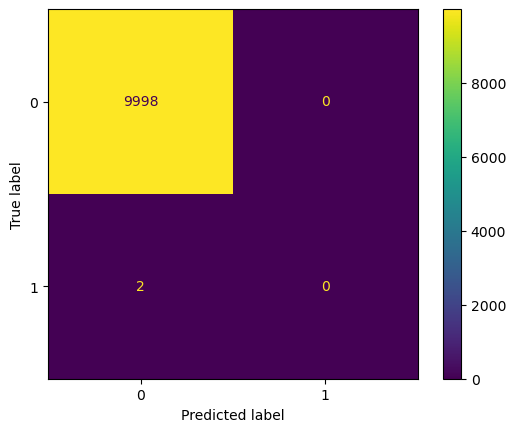

In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_predictions)
ConfusionMatrixDisplay(cm).plot()

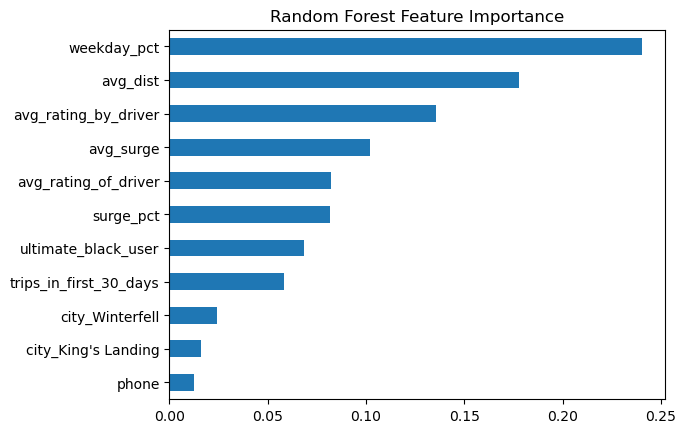

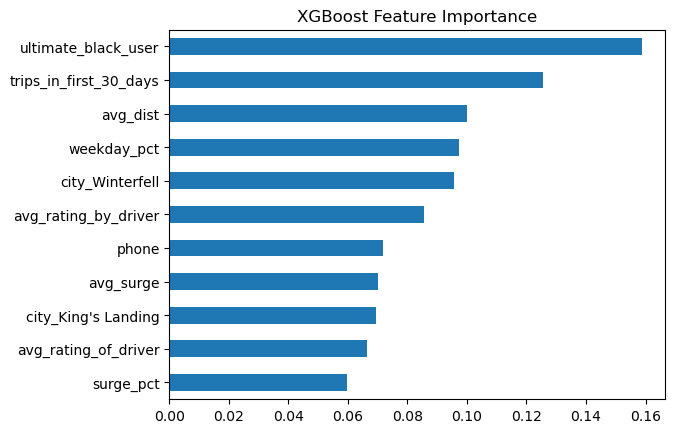

In [219]:
# Random Forest Feature Importance
importance = pd.Series(rf_model.feature_importances_, index=X_test.columns)
importance.sort_values().plot(kind='barh', title='Random Forest Feature Importance')
plt.show()

# XGBoost Feature Importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_test.columns)
xgb_importance.sort_values().plot(kind='barh', title='XGBoost Feature Importance')
plt.show()

In [177]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [173]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]})

In [227]:
best_rf_model = grid_search.best_estimator_  # Extract best model
grid_predictions = best_rf_model.predict(X_test)
grid_probabilities = best_rf_model.predict_proba(X_test)[:, 1]


Grid Search Predictions: [0 0 0 ... 0 0 0]
Grid Search Probabilities: [0. 0. 0. ... 0. 0. 0.]


In [231]:
t
print("Performance Metrics:")
print(classification_report(y_test, grid_predictions, zero_division=0))

# Print ROC-AUC score
grid_auc = roc_auc_score(y_test, grid_probabilities)
print(f"ROC-AUC Score: {grid_auc:.2f}")

Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9998
           1       0.00      0.00      0.00         2

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.49


Insights/conclusions:

Top Predictors: Features like avg_dist (average distance of trips) and weekday_pct (percentage of weekday trips) are the most influential in predicting the target variable.

Model Performance: Evaluate with accuracy, precision, recall, and F1-score.

Recommendations for Rider Retention
Engage New Users: Increase trips within the first 30 days through promotions or personalized incentives.

Driver Quality: Focus on maintaining high driver ratings to improve user satisfaction.

Weekday Trips: Design programs to encourage weekday rides (e.g., discounts).